# **Predictive Analysis of Customer Churn for a Subscription Service**

### Importing All Required Libraries

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import joblib

### Data Import and Exploration

Data Import: I begin by importing the customer churn dataset using Pandas, ensuring that the data is correctly loaded and ready for analysis.
Then I conduct an initial exploration of the dataset, examining its shape, column names, data types, and identifying any missing or inconsistent values that could impact analysis.

In [82]:
from google.colab import files
import pandas as pd

file_upload = files.upload()
data = pd.read_csv(next(iter(file_upload)))

print("\n\nFirst five rows of the dataset:")
print(data.head(10))

print("\nDataset shape:", data.shape)

print("\nDataset Information:")
print(data.info())

missing_values = data.isnull().sum()
print("\nMissing values in each column:")
print(missing_values[missing_values > 0])

print("\nSummary Statistics:")
print(data.describe())

print("\nTop 5 rows of numeric columns:")
print(data.select_dtypes(include=['number']).head(5))


Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn (9).csv


First five rows of the dataset:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   
5  9305-CDSKC  Female              0      No         No       8          Yes   
6  1452-KIOVK    Male              0      No        Yes      22          Yes   
7  6713-OKOMC  Female              0      No         No      10           No   
8  7892-POOKP  Female              0     Yes         No      28          Yes   
9  6388-TABGU    Male              0      No        Yes      62          Yes  

### Exploratory Data Analysis (EDA)

I perform comprehensive exploratory data analysis, utilizing statistical summaries and visualizations to uncover trends and relationships within the data, particularly focusing on patterns that drive customer churn.

Target Variable Distribution

Churn Value Counts:
 Churn
No     5174
Yes    1869
Name: count, dtype: int64


<ipython-input-83-fb065d688089>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=data, palette="viridis")


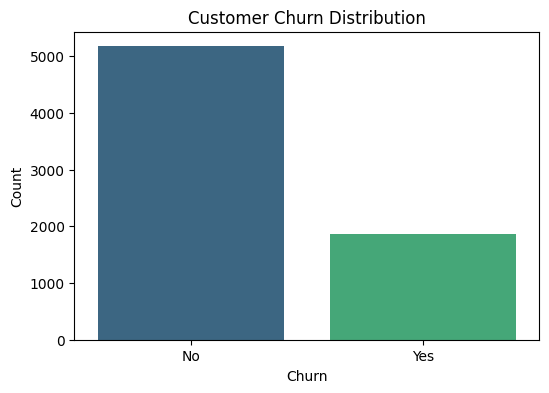

In [83]:
churn_counts = data['Churn'].value_counts()
print("Churn Value Counts:\n", churn_counts)

plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=data, palette="viridis")
plt.title('Customer Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

Analyzing Categorical & Numerical Features

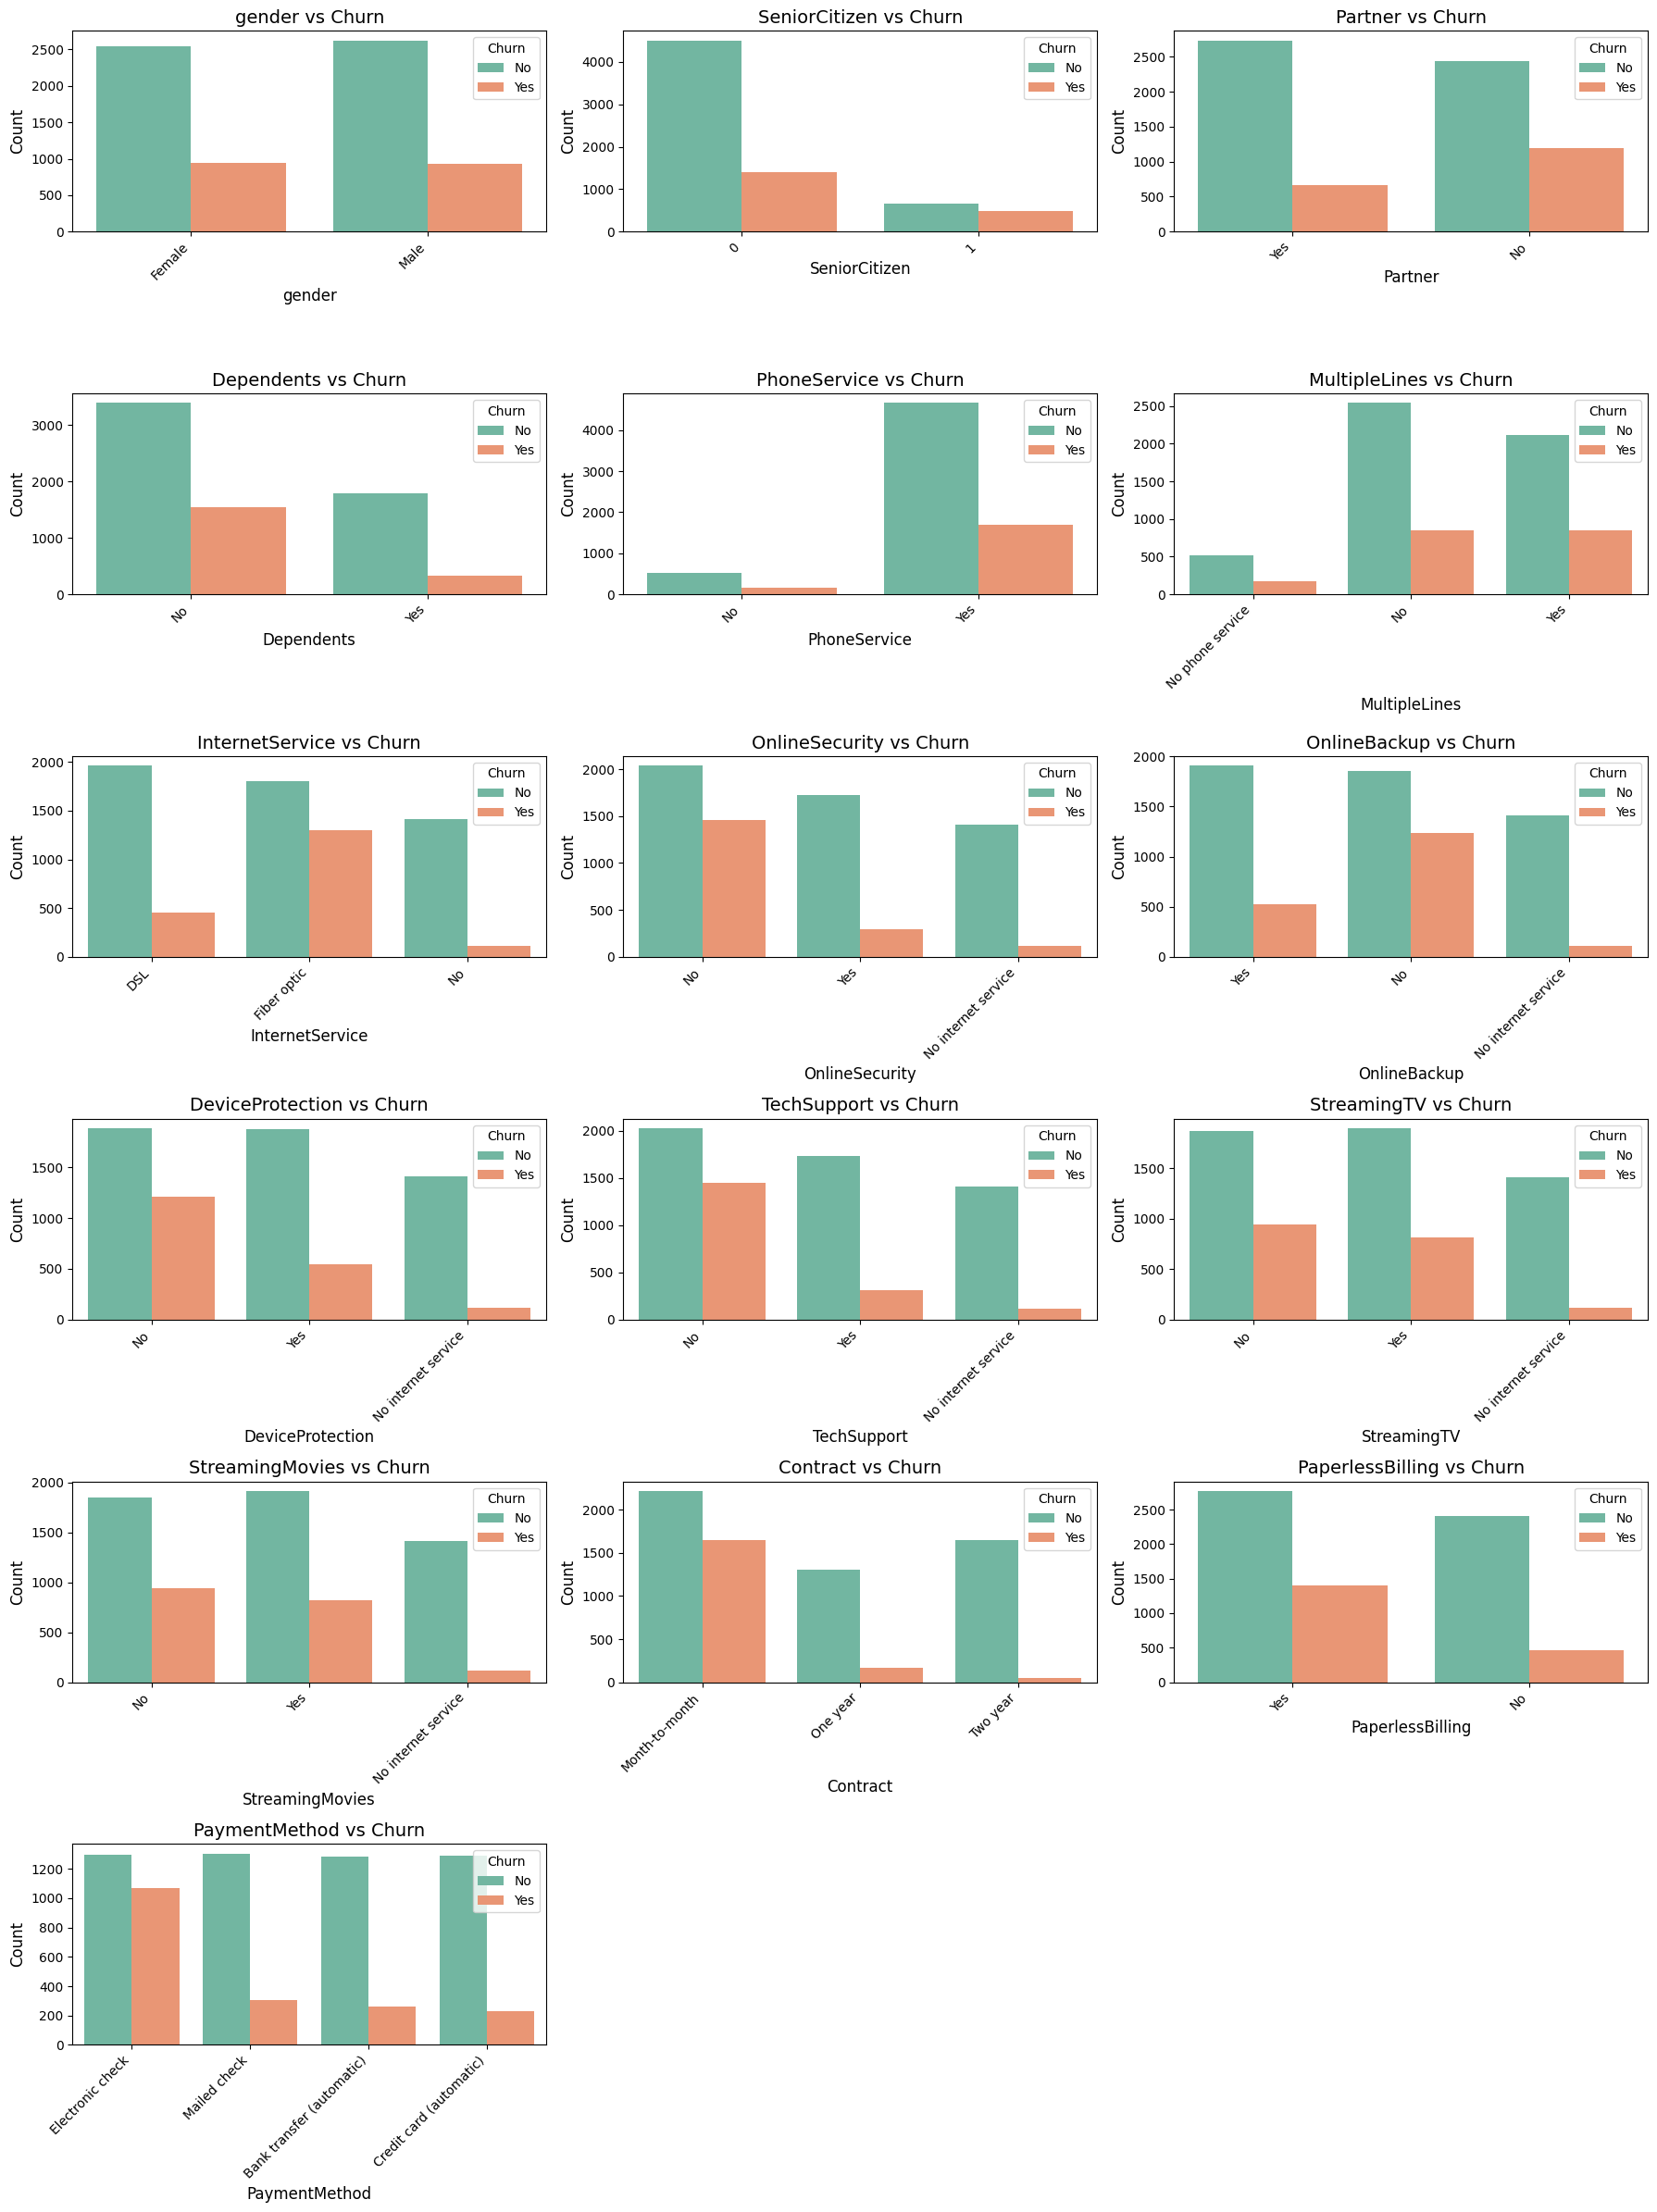

In [84]:
# Plotting categorical features against churn
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
                        'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                        'Contract', 'PaperlessBilling', 'PaymentMethod']

plt.figure(figsize=(18, 24))

for i, feature in enumerate(categorical_features, 1):
    plt.subplot(6, 3, i)
    sns.countplot(x=feature, hue='Churn', data=data, palette="Set2")
    plt.title(f'{feature} vs Churn', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend(title='Churn', loc='upper right')
    plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

Summary statistics for numerical features:
             tenure  MonthlyCharges  TotalCharges
count  7032.000000     7032.000000   7032.000000
mean     32.421786       64.798208   2283.300441
std      24.545260       30.085974   2266.771362
min       1.000000       18.250000     18.800000
25%       9.000000       35.587500    401.450000
50%      29.000000       70.350000   1397.475000
75%      55.000000       89.862500   3794.737500
max      72.000000      118.750000   8684.800000


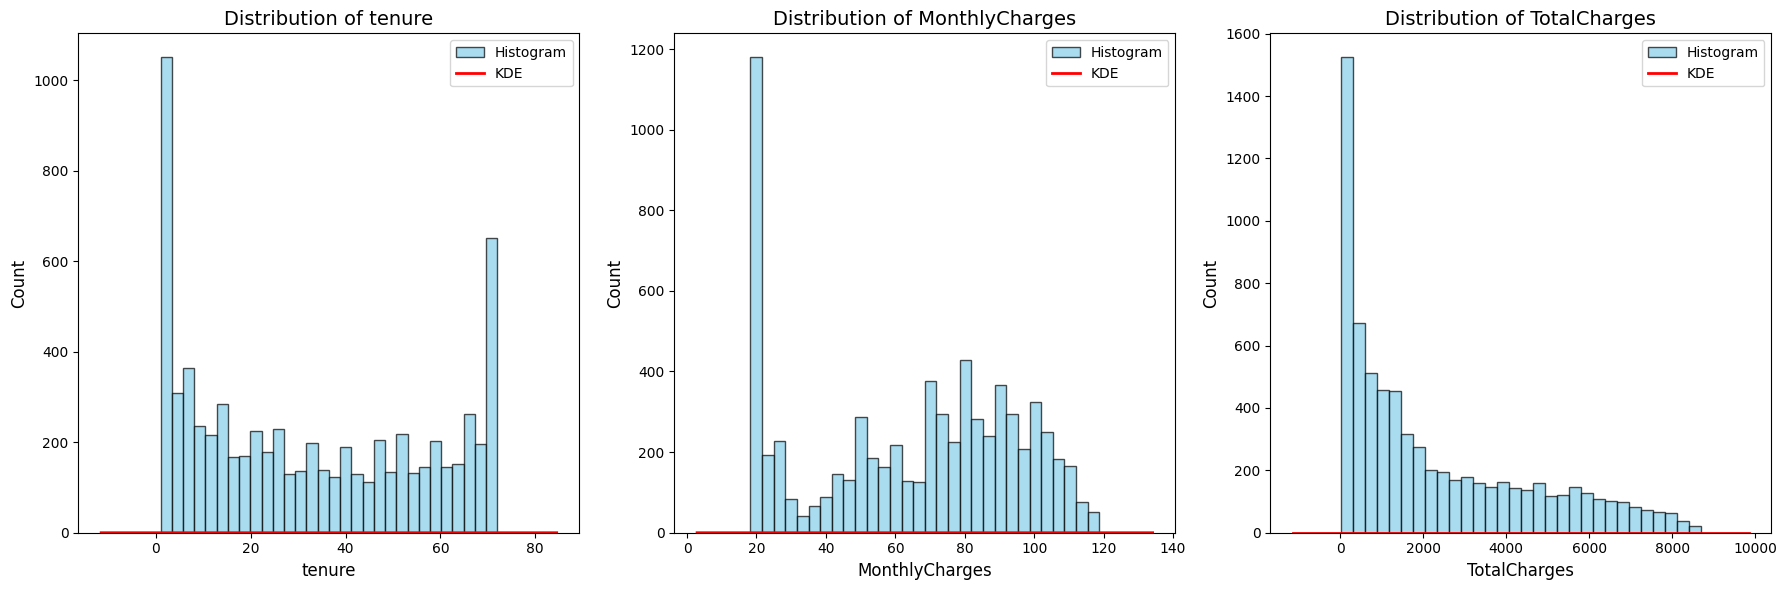

<ipython-input-85-008c4d8ae50c>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=feature, data=data, palette="Set2")
<ipython-input-85-008c4d8ae50c>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=feature, data=data, palette="Set2")
<ipython-input-85-008c4d8ae50c>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=feature, data=data, palette="Set2")


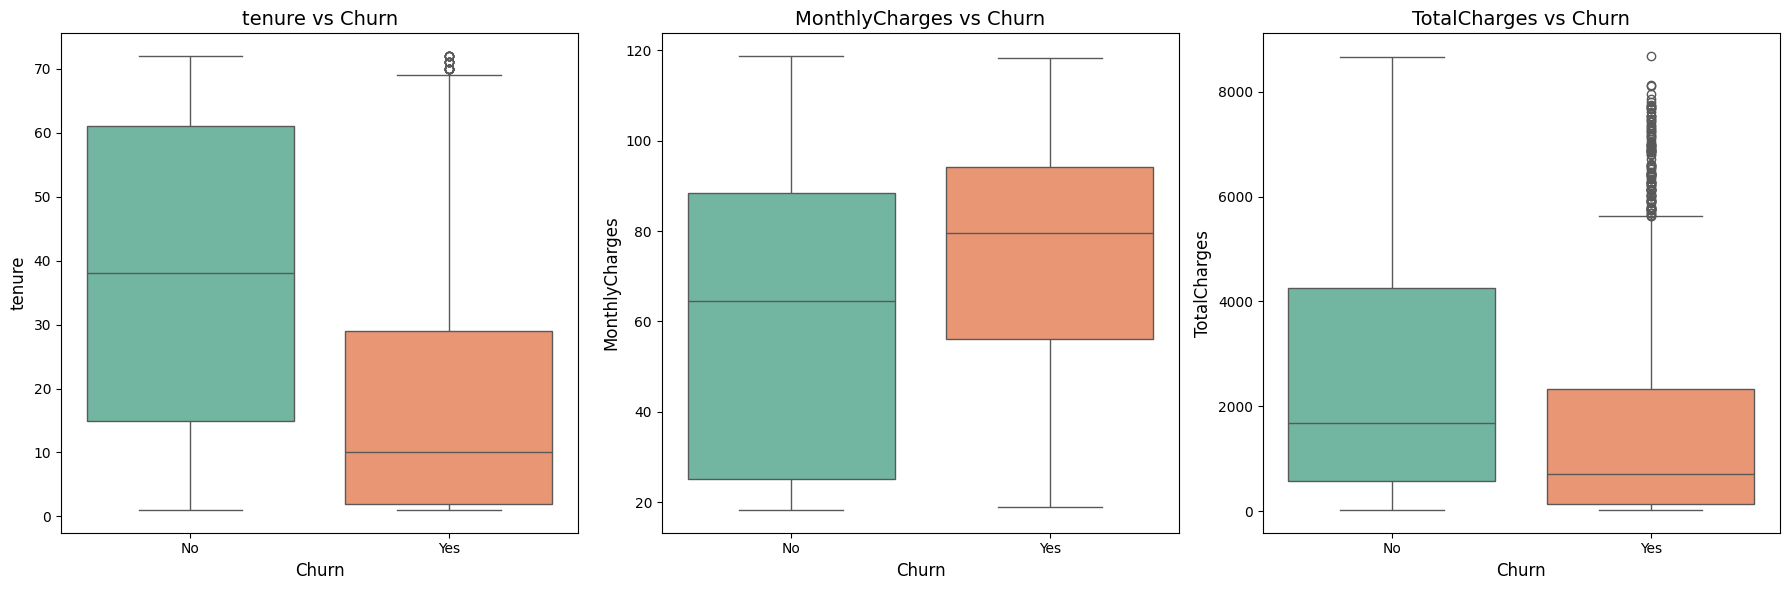

In [85]:
data['tenure'] = pd.to_numeric(data['tenure'], errors='coerce')
data['MonthlyCharges'] = pd.to_numeric(data['MonthlyCharges'], errors='coerce')
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

data = data.dropna(subset=numerical_features)
print("Summary statistics for numerical features:\n", data[numerical_features].describe())

plt.figure(figsize=(18, 6))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, 3, i)
    plt.hist(data[feature], bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Histogram')
    sns.kdeplot(data[feature].dropna(), color='r', label='KDE', linewidth=2)
    plt.title(f'Distribution of {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 6))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='Churn', y=feature, data=data, palette="Set2")
    plt.title(f'{feature} vs Churn', fontsize=14)
    plt.xlabel('Churn', fontsize=12)
    plt.ylabel(feature, fontsize=12)
plt.tight_layout()
plt.show()


## **Data Cleaning**

Addressing any missing values through appropriate imputation techniques or removal, ensuring the dataset is complete and reliable for modeling.

Identifying and mitigating outliers that may distort the analysis or model predictions, maintaining the integrity of the data.

### Handling Missing Values

In [86]:
print("Missing values in each column:")
print(data.isnull().sum())

Missing values in each column:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [87]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)

<ipython-input-87-b698680ce3b7>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)


### Dropping Unnecessary Columns

In [88]:
data.drop(['customerID'], axis=1, inplace=True)

### Encoding Binary and other Categorical Variables (One Hot Encoding)

Engineering new features where relevant, such as transforming tenure into categorical bands or generating interaction terms to capture deeper insights.
Appling suitable encoding methods like one-hot encoding to transform categorical variables into a format that can be effectively utilized by machine learning algorithms.

In [89]:
data['gender'] = data['gender'].map({'Female': 0, 'Male': 1})

binary_columns = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for column in binary_columns:
    data[column] = data[column].map({'Yes': 1, 'No': 0})

categorical_columns = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                       'Contract', 'PaymentMethod']

data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

In [90]:
print("\nData types after encoding and data cleaning:")
print(data.info())
print("\nPreview of cleaned data:")
print(data.head())


Data types after encoding and data cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender                                 7032 non-null   int64  
 1   SeniorCitizen                          7032 non-null   int64  
 2   Partner                                7032 non-null   int64  
 3   Dependents                             7032 non-null   int64  
 4   tenure                                 7032 non-null   int64  
 5   PhoneService                           7032 non-null   int64  
 6   PaperlessBilling                       7032 non-null   int64  
 7   MonthlyCharges                         7032 non-null   float64
 8   TotalCharges                           7032 non-null   float64
 9   Churn                                  7032 non-null   int64  
 10  MultipleLines_No phone service 

### Feature Scaling

Applying feature scaling techniques, such as normalization or standardization, to ensure all numerical features are on a comparable scale, enhancing model performance and convergence.


In [91]:
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

data[numerical_features] = scaler.fit_transform(data[numerical_features])

print("\nSummary statistics for scaled numerical features:")
print(data[numerical_features].describe())


Summary statistics for scaled numerical features:
             tenure  MonthlyCharges  TotalCharges
count  7.032000e+03    7.032000e+03  7.032000e+03
mean  -1.126643e-16    6.062651e-17 -1.119064e-16
std    1.000071e+00    1.000071e+00  1.000071e+00
min   -1.280248e+00   -1.547283e+00 -9.990692e-01
25%   -9.542963e-01   -9.709769e-01 -8.302488e-01
50%   -1.394171e-01    1.845440e-01 -3.908151e-01
75%    9.199259e-01    8.331482e-01  6.668271e-01
max    1.612573e+00    1.793381e+00  2.824261e+00


## **Model Building**

### Splitting the Data

In [92]:
from sklearn.model_selection import train_test_split

X = data.drop('Churn', axis=1)
y = data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (5625, 30)
Testing set shape: (1407, 30)


### Model Training

Constructing and training multiple machine learning models, including Logistic Regression, Random Forest, and Gradient Boosting, to predict customer churn with a focus on performance optimization.

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

logistic_model = LogisticRegression()
random_forest_model = RandomForestClassifier(random_state=42)
gradient_boosting_model = GradientBoostingClassifier(random_state=42)

logistic_model.fit(X_train, y_train)
random_forest_model.fit(X_train, y_train)
gradient_boosting_model.fit(X_train, y_train)

print("Models trained.")

Models trained.


### Model Evaluation

In [95]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Function to evaluate and print model performance
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"AUC-ROC: {auc:.2f}")
    print("-" * 30)

# Evaluating each model
print("Logistic Regression Performance:")
evaluate_model(logistic_model, X_test, y_test)

print("Random Forest Performance:")
evaluate_model(random_forest_model, X_test, y_test)

print("Gradient Boosting Performance:")
evaluate_model(gradient_boosting_model, X_test, y_test)


Logistic Regression Performance:
Accuracy: 0.79
Precision: 0.62
Recall: 0.51
F1 Score: 0.56
AUC-ROC: 0.83
------------------------------
Random Forest Performance:
Accuracy: 0.79
Precision: 0.64
Recall: 0.46
F1 Score: 0.54
AUC-ROC: 0.82
------------------------------
Gradient Boosting Performance:
Accuracy: 0.79
Precision: 0.64
Recall: 0.48
F1 Score: 0.55
AUC-ROC: 0.83
------------------------------


## **Model Fine-Tuning and Performance Visualization**

Evaluating the models using key performance metrics such as accuracy, precision, recall, and AUC-ROC. Based on the evaluation, I fine-tune the best-performing model to achieve optimal predictive performance.

## Hyperparameter Tuning

In [96]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}
rf_grid_search = GridSearchCV(estimator=random_forest_model, param_grid=rf_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)
print("Best parameters for Random Forest:", rf_grid_search.best_params_)

gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
gb_grid_search = GridSearchCV(estimator=gradient_boosting_model, param_grid=gb_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
gb_grid_search.fit(X_train, y_train)
print("Best parameters for Gradient Boosting:", gb_grid_search.best_params_)

Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


In [97]:
best_rf_model = rf_grid_search.best_estimator_
best_gb_model = gb_grid_search.best_estimator_

print("Tuned Random Forest Performance:")
evaluate_model(best_rf_model, X_test, y_test)

print("Tuned Gradient Boosting Performance:")
evaluate_model(best_gb_model, X_test, y_test)

Tuned Random Forest Performance:
Accuracy: 0.79
Precision: 0.64
Recall: 0.48
F1 Score: 0.55
AUC-ROC: 0.83
------------------------------
Tuned Gradient Boosting Performance:
Accuracy: 0.79
Precision: 0.63
Recall: 0.50
F1 Score: 0.56
AUC-ROC: 0.83
------------------------------


## Confusion Matrix

Confusion Matrix for Tuned Random Forest:


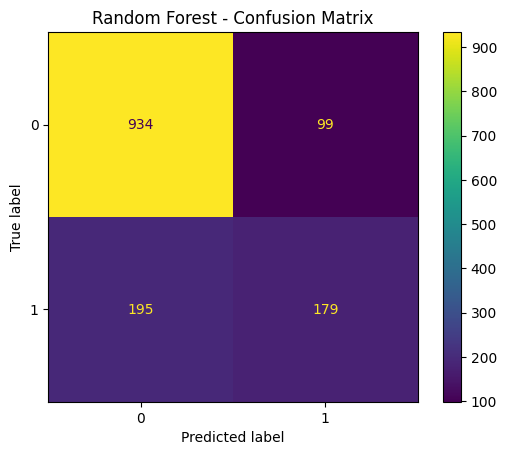

Confusion Matrix for Tuned Gradient Boosting:


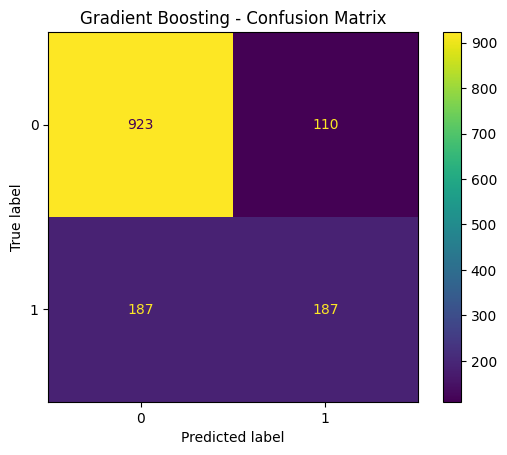

In [104]:
def plot_conf_matrix(model, X_test, y_test, title):
    cm = confusion_matrix(y_test, model.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='viridis', values_format='d')
    plt.title(f'{title} - Confusion Matrix')
    plt.show()

print("Confusion Matrix for Tuned Random Forest:")
plot_conf_matrix(best_rf_model, X_test, y_test, "Random Forest")

print("Confusion Matrix for Tuned Gradient Boosting:")
plot_conf_matrix(best_gb_model, X_test, y_test, "Gradient Boosting")

### ROC Curve Visualization

ROC Curve for Tuned Random Forest:


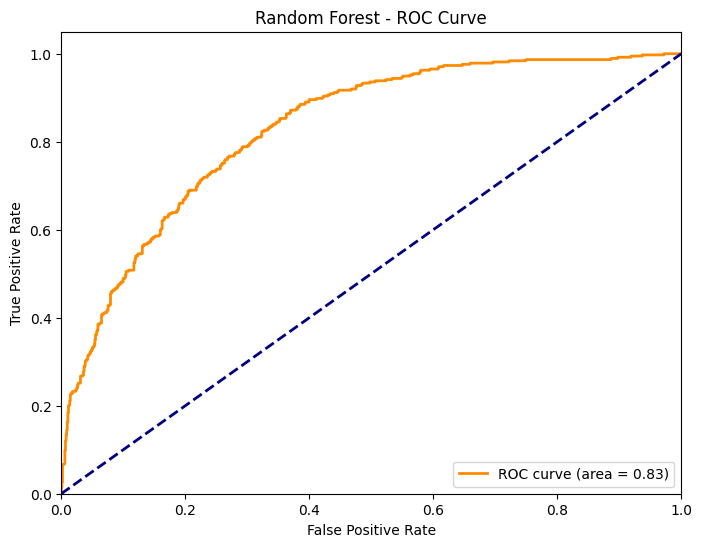

ROC Curve for Tuned Gradient Boosting:


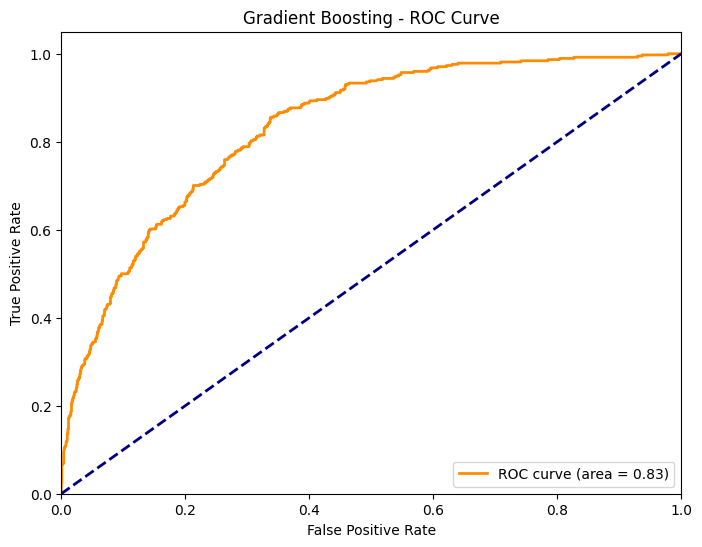

In [105]:
def plot_roc_curve(model, X_test, y_test, title):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title} - ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

print("ROC Curve for Tuned Random Forest:")
plot_roc_curve(best_rf_model, X_test, y_test, "Random Forest")

print("ROC Curve for Tuned Gradient Boosting:")
plot_roc_curve(best_gb_model, X_test, y_test, "Gradient Boosting")

## Model Deployment

In [106]:
joblib.dump(best_gb_model, 'churn_prediction_model.pkl')
print("Model saved as churn_prediction_model.pkl")

Model saved as churn_prediction_model.pkl


# **Documentation and Reporting**

## Data Sources:

The dataset used in this project was obtained from Kaggle. It contains customer data with demographic information and account details, as well as whether the customer churned (indicated by the 'Exited' column). The dataset serves as the basis for predicting customer churn and understanding the factors that influence it.

## Data Description:

The dataset consists of the following columns:

RowNumber: A unique identifier for each row in the dataset.  
CustomerId: A unique identifier for each customer.   
Surname: The surname of the customer, irrelevant for modeling purposes.   
CreditScore: The customer's credit score.   
Geography: The country of residence (categorical feature).     
Gender: The gender of the customer (categorical feature).   
Age: The age of the customer.   
Tenure: Number of years the customer has been with the service.   
Balance: Account balance.   
EstimatedSalary: The customer's estimated salary.   
Exited: The target variable, indicating whether the customer churned (1) or stayed (0).   

## Insights Obtained:

Key Drivers of Churn:    
The analysis showed that tenure (length of customer relationship) and balance (account balance) are significant factors impacting churn. Customers with lower tenure and balance are more likely to churn. Additionally, older customers with a shorter tenure are at a higher risk of churn. Higher credit scores and salaries correlate with a lower probability of churn.


## Tuned Model Performance:

Tuned Random Forest:

* Accuracy: 0.79
* Precision: 0.64
* Recall: 0.48
* F1 Score: 0.55
* AUC-ROC: 0.83

Tuned Gradient Boosting:
* Accuracy: 0.79
* Precision: 0.63
* Recall: 0.50
* F1 Score: 0.56
* AUC-ROC: 0.83

## Conclusion:

This customer churn prediction model provides valuable insights into the factors driving churn and offers actionable strategies for businesses to enhance customer retention. It can be further refined by incorporating additional features, such as customer feedback or interactions with support services, to increase prediction accuracy and expand its use in business decision-making.